# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /mnt/c/Users/t-kaspermalm/Documents/code/github/kth/mlfs-book
HopsworksSettings initialized!


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 17, 21, 11, 12, 519282)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-17 21:11:12,543 INFO: Initializing external client
2025-11-17 21:11:12,544 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-17 21:11:13,290 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-17 21:11:14,209 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1271978


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [ ]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model_cloud_cover_lag",
    version=4,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-17 21:11:16,676 INFO: There is no parent information


Downloading: 0.000%|          | 0/543499 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/104685 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/51218 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/16325 elapsed<00:00 remaining<?

In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='4.5132874E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'floa...
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (-1.91s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-19 00:00:00+00:00,2.05,0.4,2.545584,224.999893,berlin
1,2025-11-18 00:00:00+00:00,0.25,0.0,11.520000,270.000000,berlin
2,2025-11-23 00:00:00+00:00,-1.25,0.0,2.305125,321.340179,berlin
3,2025-11-22 00:00:00+00:00,5.75,0.0,9.360000,360.000000,berlin
4,2025-11-20 00:00:00+00:00,5.20,0.0,6.214563,10.007925,berlin
5,2025-11-21 00:00:00+00:00,5.60,0.0,3.096837,215.537766,berlin


In [8]:
import pandas as pd

today_str = pd.to_datetime(today).strftime('%Y-%m-%d')

cloud_cover_fg = fs.get_feature_group(
    name='cloud_cover',
    version=1,
)
cloud_cover_batch_data = cloud_cover_fg.filter(cloud_cover_fg.date >= today_str).read()
cloud_cover_batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.75s) 


,date,cloud_cover,city
0,2025-11-17,41,berlin
1,2025-11-21,90,berlin
2,2025-11-20,99,berlin
3,2025-11-23,40,berlin
4,2025-11-22,93,berlin
5,2025-11-18,52,berlin
6,2025-11-19,92,berlin


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [9]:
import pandas as pd

# Ensure both 'date' columns are datetime (no timezone)
batch_data['date'] = pd.to_datetime(batch_data['date']).dt.tz_localize(None)
cloud_cover_batch_data['date'] = pd.to_datetime(cloud_cover_batch_data['date']).dt.tz_localize(None)

# Merge cloud_cover
batch_data = batch_data.merge(
    cloud_cover_batch_data[['date', 'cloud_cover']],
    on='date',
    how='left'
)

In [10]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         6 non-null      datetime64[us]
 1   temperature_2m_mean          6 non-null      float32       
 2   precipitation_sum            6 non-null      float32       
 3   wind_speed_10m_max           6 non-null      float32       
 4   wind_direction_10m_dominant  6 non-null      float32       
 5   city                         6 non-null      object        
 6   cloud_cover                  6 non-null      int64         
dtypes: datetime64[us](1), float32(4), int64(1), object(1)
memory usage: 368.0+ bytes


In [11]:
lag_days = [1, 2, 3]
lag_features = ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 
                'wind_direction_10m_dominant', 'cloud_cover']

for col in lag_features:
    for lag in lag_days:
        batch_data[f"{col}_minus_{lag}"] = batch_data[col].shift(lag)

In [12]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 6 non-null      datetime64[us]
 1   temperature_2m_mean                  6 non-null      float32       
 2   precipitation_sum                    6 non-null      float32       
 3   wind_speed_10m_max                   6 non-null      float32       
 4   wind_direction_10m_dominant          6 non-null      float32       
 5   city                                 6 non-null      object        
 6   cloud_cover                          6 non-null      int64         
 7   temperature_2m_mean_minus_1          5 non-null      float32       
 8   temperature_2m_mean_minus_2          4 non-null      float32       
 9   temperature_2m_mean_minus_3          3 non-null      float32       
 10  precipitation_sum_

In [13]:
import pandas as pd

# Ensure both 'date' columns are datetime (no timezone)
batch_data['date'] = pd.to_datetime(batch_data['date']).dt.tz_localize(None)
cloud_cover_batch_data['date'] = pd.to_datetime(cloud_cover_batch_data['date']).dt.tz_localize(None)

# Merge cloud_cover
"""
batch_data = batch_data.merge(
    cloud_cover_batch_data[['date', 'cloud_cover']],
    on='date',
    how='left'
)
"""
batch_data.info()

"""
# Predict
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'cloud_cover']]
)
"""

batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'cloud_cover', 'temperature_2m_mean_minus_1', 'temperature_2m_mean_minus_2', 'temperature_2m_mean_minus_3', 'precipitation_sum_minus_1', 'precipitation_sum_minus_2', 'precipitation_sum_minus_3', 'wind_speed_10m_max_minus_1', 'wind_speed_10m_max_minus_2', 'wind_speed_10m_max_minus_3', 'wind_direction_10m_dominant_minus_1', 'wind_direction_10m_dominant_minus_2', 'wind_direction_10m_dominant_minus_3', 'cloud_cover_minus_1', 'cloud_cover_minus_2', 'cloud_cover_minus_3']]
)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 6 non-null      datetime64[us]
 1   temperature_2m_mean                  6 non-null      float32       
 2   precipitation_sum                    6 non-null      float32       
 3   wind_speed_10m_max                   6 non-null      float32       
 4   wind_direction_10m_dominant          6 non-null      float32       
 5   city                                 6 non-null      object        
 6   cloud_cover                          6 non-null      int64         
 7   temperature_2m_mean_minus_1          5 non-null      float32       
 8   temperature_2m_mean_minus_2          4 non-null      float32       
 9   temperature_2m_mean_minus_3          3 non-null      float32       
 10  precipitation_sum_

In [14]:
lag_days = [1, 2, 3]
lag_features = ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 
                'wind_direction_10m_dominant', 'cloud_cover']

for col in lag_features:
    for lag in lag_days:
        batch_data[f"{col}_minus_{lag}"] = batch_data[col].shift(lag)


In [15]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 6 non-null      datetime64[us]
 1   temperature_2m_mean                  6 non-null      float32       
 2   precipitation_sum                    6 non-null      float32       
 3   wind_speed_10m_max                   6 non-null      float32       
 4   wind_direction_10m_dominant          6 non-null      float32       
 5   city                                 6 non-null      object        
 6   cloud_cover                          6 non-null      int64         
 7   temperature_2m_mean_minus_1          5 non-null      float32       
 8   temperature_2m_mean_minus_2          4 non-null      float32       
 9   temperature_2m_mean_minus_3          3 non-null      float32       
 10  precipitation_sum_

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [16]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,cloud_cover,temperature_2m_mean_minus_1,temperature_2m_mean_minus_2,temperature_2m_mean_minus_3,...,wind_direction_10m_dominant_minus_1,wind_direction_10m_dominant_minus_2,wind_direction_10m_dominant_minus_3,cloud_cover_minus_1,cloud_cover_minus_2,cloud_cover_minus_3,predicted_pm25,street,country,days_before_forecast_day
1,2025-11-18,0.25,0.0,11.520000,270.000000,berlin,52,2.05,NaN,NaN,...,224.999893,NaN,NaN,92.0,NaN,NaN,43.181931,mitte--bruckenstrasse,germany,2
0,2025-11-19,2.05,0.4,2.545584,224.999893,berlin,92,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,24.681555,mitte--bruckenstrasse,germany,1
4,2025-11-20,5.20,0.0,6.214563,10.007925,berlin,99,5.75,-1.25,0.25,...,360.000000,321.340179,270.000000,93.0,40.0,52.0,40.796795,mitte--bruckenstrasse,germany,5
5,2025-11-21,5.60,0.0,3.096837,215.537766,berlin,90,5.20,5.75,-1.25,...,10.007925,360.000000,321.340179,99.0,93.0,40.0,25.262087,mitte--bruckenstrasse,germany,6
3,2025-11-22,5.75,0.0,9.360000,360.000000,berlin,93,-1.25,0.25,2.05,...,321.340179,270.000000,224.999893,40.0,52.0,92.0,37.414093,mitte--bruckenstrasse,germany,4
2,2025-11-23,-1.25,0.0,2.305125,321.340179,berlin,40,0.25,2.05,NaN,...,270.000000,224.999893,NaN,52.0,92.0,NaN,49.010216,mitte--bruckenstrasse,germany,3


In [17]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 1 to 2
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 6 non-null      datetime64[us]
 1   temperature_2m_mean                  6 non-null      float32       
 2   precipitation_sum                    6 non-null      float32       
 3   wind_speed_10m_max                   6 non-null      float32       
 4   wind_direction_10m_dominant          6 non-null      float32       
 5   city                                 6 non-null      object        
 6   cloud_cover                          6 non-null      int64         
 7   temperature_2m_mean_minus_1          5 non-null      float32       
 8   temperature_2m_mean_minus_2          4 non-null      float32       
 9   temperature_2m_mean_minus_3          3 non-null      float32       
 10  precipitation_sum_minus

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2025-11-17 21:11:23,763 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



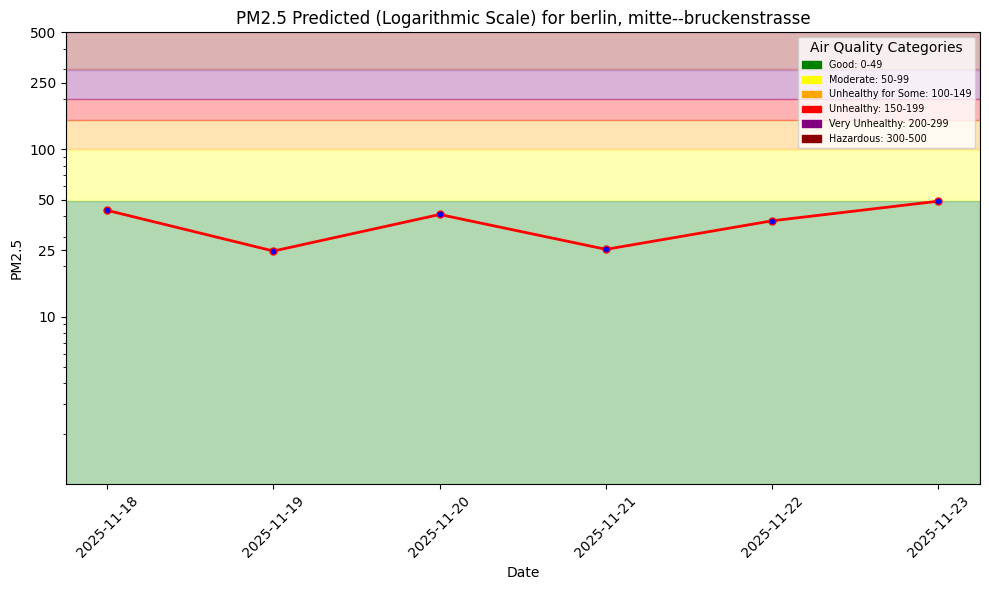

In [18]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_cloud_cover_lag.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [19]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions_cloud_cover_lag',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [20]:
print("DataFrame columns:", batch_data.columns.tolist())

DataFrame columns: ['date', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'city', 'cloud_cover', 'temperature_2m_mean_minus_1', 'temperature_2m_mean_minus_2', 'temperature_2m_mean_minus_3', 'precipitation_sum_minus_1', 'precipitation_sum_minus_2', 'precipitation_sum_minus_3', 'wind_speed_10m_max_minus_1', 'wind_speed_10m_max_minus_2', 'wind_speed_10m_max_minus_3', 'wind_direction_10m_dominant_minus_1', 'wind_direction_10m_dominant_minus_2', 'wind_direction_10m_dominant_minus_3', 'cloud_cover_minus_1', 'cloud_cover_minus_2', 'cloud_cover_minus_3', 'predicted_pm25', 'street', 'country', 'days_before_forecast_day']


In [21]:
expected_cols = [f.name for f in monitor_fg.features]
print("Feature Group columns:", expected_cols)

Feature Group columns: ['date', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'city', 'cloud_cover', 'temperature_2m_mean_minus_1', 'temperature_2m_mean_minus_2', 'temperature_2m_mean_minus_3', 'precipitation_sum_minus_1', 'precipitation_sum_minus_2', 'precipitation_sum_minus_3', 'wind_speed_10m_max_minus_1', 'wind_speed_10m_max_minus_2', 'wind_speed_10m_max_minus_3', 'wind_direction_10m_dominant_minus_1', 'wind_direction_10m_dominant_minus_2', 'wind_direction_10m_dominant_minus_3', 'cloud_cover_minus_1', 'cloud_cover_minus_2', 'cloud_cover_minus_3', 'predicted_pm25', 'street', 'country', 'days_before_forecast_day']


In [22]:
#monitor_fg.delete()

In [23]:
print(batch_data.columns)

Index(['date', 'temperature_2m_mean', 'precipitation_sum',
       'wind_speed_10m_max', 'wind_direction_10m_dominant', 'city',
       'cloud_cover', 'temperature_2m_mean_minus_1',
       'temperature_2m_mean_minus_2', 'temperature_2m_mean_minus_3',
       'precipitation_sum_minus_1', 'precipitation_sum_minus_2',
       'precipitation_sum_minus_3', 'wind_speed_10m_max_minus_1',
       'wind_speed_10m_max_minus_2', 'wind_speed_10m_max_minus_3',
       'wind_direction_10m_dominant_minus_1',
       'wind_direction_10m_dominant_minus_2',
       'wind_direction_10m_dominant_minus_3', 'cloud_cover_minus_1',
       'cloud_cover_minus_2', 'cloud_cover_minus_3', 'predicted_pm25',
       'street', 'country', 'days_before_forecast_day'],
      dtype='object')


In [24]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_cloud_cover_lag_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1271978/jobs/named/aq_predictions_cloud_cover_lag_1_offline_fg_materialization/executions
2025-11-17 21:11:43,239 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-17 21:11:46,465 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-17 21:13:21,348 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-17 21:13:21,518 INFO: Waiting for log aggregation to finish.
2025-11-17 21:13:30,286 INFO: Execution finished successfully.


(Job('aq_predictions_cloud_cover_lag_1_offline_fg_materialization', 'SPARK'),
 None)

In [25]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.44s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,cloud_cover,temperature_2m_mean_minus_1,temperature_2m_mean_minus_2,temperature_2m_mean_minus_3,...,wind_direction_10m_dominant_minus_1,wind_direction_10m_dominant_minus_2,wind_direction_10m_dominant_minus_3,cloud_cover_minus_1,cloud_cover_minus_2,cloud_cover_minus_3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-19 00:00:00+00:00,2.05,0.4,2.545584,224.999893,berlin,92,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,24.681555,mitte--bruckenstrasse,germany,1


In [26]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.04s) 


,date,pm25,country,city,street,url
0,2025-05-14 00:00:00+00:00,40.0,germany,berlin,mitte--bruckenstrasse,https://api.waqi.info/feed/@10039
1,2024-02-22 00:00:00+00:00,24.0,germany,berlin,mitte--bruckenstrasse,https://api.waqi.info/feed/@10039
2,2022-11-27 00:00:00+00:00,65.0,germany,berlin,mitte--bruckenstrasse,https://api.waqi.info/feed/@10039
3,2024-09-20 00:00:00+00:00,61.0,germany,berlin,mitte--bruckenstrasse,https://api.waqi.info/feed/@10039
4,2023-01-29 00:00:00+00:00,58.0,germany,berlin,mitte--bruckenstrasse,https://api.waqi.info/feed/@10039
...,...,...,...,...,...,...
1355,2024-11-05 00:00:00+00:00,61.0,germany,berlin,mitte--bruckenstrasse,https://api.waqi.info/feed/@10039
1356,2023-07-01 00:00:00+00:00,36.0,germany,berlin,mitte--bruckenstrasse,https://api.waqi.info/feed/@10039
1357,2022-06-23 00:00:00+00:00,34.0,germany,berlin,mitte--bruckenstrasse,https://api.waqi.info/feed/@10039
1358,2025-04-30 00:00:00+00:00,33.0,germany,berlin,mitte--bruckenstrasse,https://api.waqi.info/feed/@10039


In [27]:
print(air_quality_df.columns)
print(monitoring_df.columns)

Index(['date', 'pm25', 'country', 'city', 'street', 'url'], dtype='object')
Index(['date', 'temperature_2m_mean', 'precipitation_sum',
       'wind_speed_10m_max', 'wind_direction_10m_dominant', 'city',
       'cloud_cover', 'temperature_2m_mean_minus_1',
       'temperature_2m_mean_minus_2', 'temperature_2m_mean_minus_3',
       'precipitation_sum_minus_1', 'precipitation_sum_minus_2',
       'precipitation_sum_minus_3', 'wind_speed_10m_max_minus_1',
       'wind_speed_10m_max_minus_2', 'wind_speed_10m_max_minus_3',
       'wind_direction_10m_dominant_minus_1',
       'wind_direction_10m_dominant_minus_2',
       'wind_direction_10m_dominant_minus_3', 'cloud_cover_minus_1',
       'cloud_cover_minus_2', 'cloud_cover_minus_3', 'predicted_pm25',
       'street', 'country', 'days_before_forecast_day'],
      dtype='object')


In [28]:
print(retrieved_xgboost_model.get_booster().feature_names)

['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'cloud_cover', 'temperature_2m_mean_minus_1', 'temperature_2m_mean_minus_2', 'temperature_2m_mean_minus_3', 'precipitation_sum_minus_1', 'precipitation_sum_minus_2', 'precipitation_sum_minus_3', 'wind_speed_10m_max_minus_1', 'wind_speed_10m_max_minus_2', 'wind_speed_10m_max_minus_3', 'wind_direction_10m_dominant_minus_1', 'wind_direction_10m_dominant_minus_2', 'wind_direction_10m_dominant_minus_3', 'cloud_cover_minus_1', 'cloud_cover_minus_2', 'cloud_cover_minus_3']


In [29]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring_cloud_cover_lag(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.04s) 


FeatureStoreException: Features are not compatible with Feature Group schema: 
 - cloud_cover_minus_1 (expected type: 'double', derived from input: 'bigint') has the wrong type.
 - cloud_cover_minus_2 (expected type: 'double', derived from input: 'float') has the wrong type.
 - cloud_cover_minus_3 (expected type: 'double', derived from input: 'float') has the wrong type.
Note that feature (or column) names are case insensitive and spaces are automatically replaced with underscores.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_true = hindcast_df['pm25']
y_pred = hindcast_df['predicted_pm25']

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mean_error = (y_pred - y_true).mean()
std_error = (y_pred - y_true).std()
r2 = r2_score(y_true, y_pred)

print(f"Mean Error: {mean_error:.2f}")
print(f"Std of Error: {std_error:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

2025-11-17 16:43:51,365 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-11-17 16:43:51,366 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

In [ ]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_cloud_cover_lag.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [ ]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}_cloud_cover_lag", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}_cloud_cover_lag", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

---